# Adding new samples to embedding

This notebook demonstrates how to embed new, unseen samples into an existing t-SNE embedding. Basic usage is described in detail in `simple_usage.ipynb`, so a lot of details on t-SNE are skipped here.

In [1]:
from fastTSNE import TSNE
from fastTSNE.callbacks import ErrorLogger

from examples import utils

import numpy as np
import scipy.sparse as sp
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

### Load data

In this notebook, we'll be using the Zeisel 2018 mouse nervous system data set. Most often, the MNIST digit data set is used to benchmark t-SNE, however this data set is even larger. It contains around 160k samples, which is more than twice the size of MNIST (70k samples). This was done purely to demonstrate the speed of the library.

The data set can be obtained through [Linnarsson Lab](https://storage.googleapis.com/linnarsson-lab-loom/l5_all.loom), but it is 18GB, so download at your own peril.

In [2]:
x, y = utils.get_zeisel_2018()

# x and y have the following data types
x: sp.spmatrix
y: np.ndarray

In [3]:
print('Data set contains %d samples with %d features' % x.shape)

Data set contains 160796 samples with 27932 features


### Create train/test split

In [4]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.3)

In [5]:
print('%d training samples' % x_train.shape[0])
print('%d test samples' % x_test.shape[0])

112557 training samples
48239 test samples


### SVD preprocessing

In [6]:
svd = TruncatedSVD(n_components=50)

In [7]:
%time x_train_prime = svd.fit_transform(x_train)

CPU times: user 53.3 s, sys: 740 ms, total: 54.1 s
Wall time: 42.9 s


### t-SNE

In [8]:
tsne = TSNE(n_components=2, negative_gradient_method='fft', neighbors='approx',
            callbacks=ErrorLogger(), n_jobs=8)

In [9]:
%time embedding_train = tsne.fit(x_train_prime)

Iteration   50, KL divergence  8.0065, 50 iterations in 2.9017 sec
Iteration  100, KL divergence  7.1367, 50 iterations in 3.1081 sec
Iteration  150, KL divergence  6.3660, 50 iterations in 2.9177 sec
Iteration  200, KL divergence  5.9217, 50 iterations in 2.8259 sec
Iteration  250, KL divergence  5.6360, 50 iterations in 2.8962 sec
Iteration   50, KL divergence  5.4817, 50 iterations in 2.8960 sec
Iteration  100, KL divergence  5.2186, 50 iterations in 2.9693 sec
Iteration  150, KL divergence  4.9399, 50 iterations in 3.0098 sec
Iteration  200, KL divergence  4.6797, 50 iterations in 3.1120 sec
Iteration  250, KL divergence  4.4522, 50 iterations in 3.1661 sec
Iteration  300, KL divergence  4.2557, 50 iterations in 3.2244 sec
Iteration  350, KL divergence  4.0865, 50 iterations in 3.3290 sec
Iteration  400, KL divergence  3.9404, 50 iterations in 3.3766 sec
Iteration  450, KL divergence  3.8128, 50 iterations in 3.6339 sec
Iteration  500, KL divergence  3.7009, 50 iterations in 3.5052

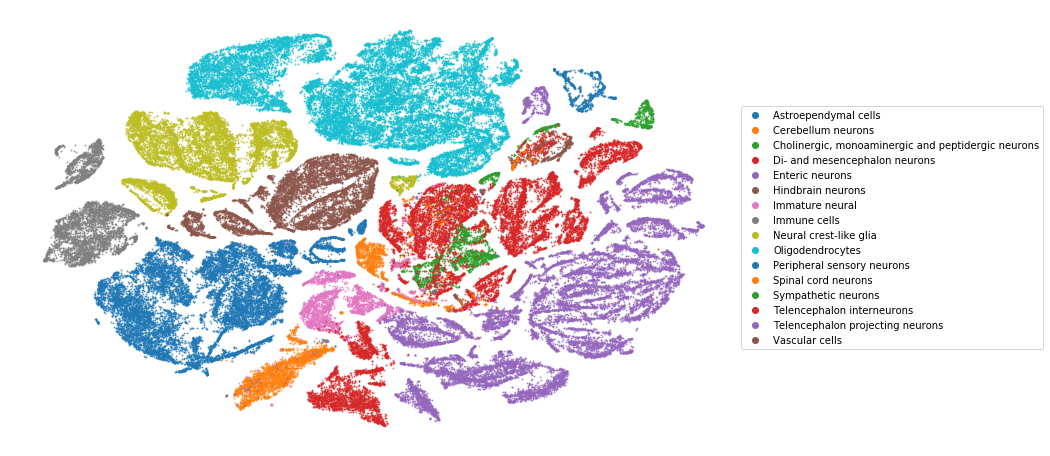

In [10]:
fig = plt.figure(figsize=(13, 8))
utils.plot(embedding_train, y_train, ax=fig.gca())

### Embedding new samples

First, we need to project the test data into the same reduced space as the training data.

In [11]:
%time x_prime_test = svd.transform(x_test)

CPU times: user 1.44 s, sys: 0 ns, total: 1.44 s
Wall time: 1.43 s


Now, we can add samples in this reduced representations to the embedding and optimize for a couple hundred iterations.

In [12]:
%time embedding_test = embedding_train.transform(x_prime_test)

Iteration   50, KL divergence  3.6424, 50 iterations in 2.4538 sec
Iteration  100, KL divergence  3.5873, 50 iterations in 2.7035 sec
Iteration   50, KL divergence  3.5810, 50 iterations in 2.5540 sec
Iteration  100, KL divergence  3.5726, 50 iterations in 2.2995 sec
Iteration  150, KL divergence  3.5657, 50 iterations in 2.5189 sec
Iteration  200, KL divergence  3.5606, 50 iterations in 2.7198 sec
Iteration  250, KL divergence  3.5571, 50 iterations in 2.6526 sec
Iteration  300, KL divergence  3.5554, 50 iterations in 2.4964 sec
CPU times: user 2min 53s, sys: 7.29 s, total: 3min
Wall time: 26.7 s


Let's plot the newly embedded data.

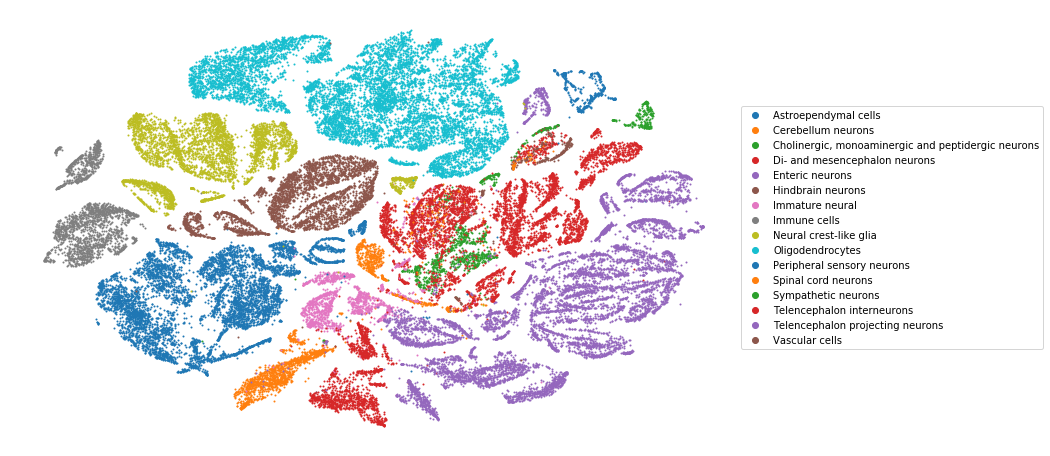

In [13]:
fig = plt.figure(figsize=(13, 8))
utils.plot(embedding_test, y_test, ax=fig.gca(), alpha=1)

Looks familliar, doesn't it? If we compare this to the above plot, we can see that the colors match up.

We superimpose the embedded test samples over the training samples in the hope that the correspondence will be even clearer. We plot the training samples with high transparency, and the test samples with no transparency so hopefully, they stand out a bit more.

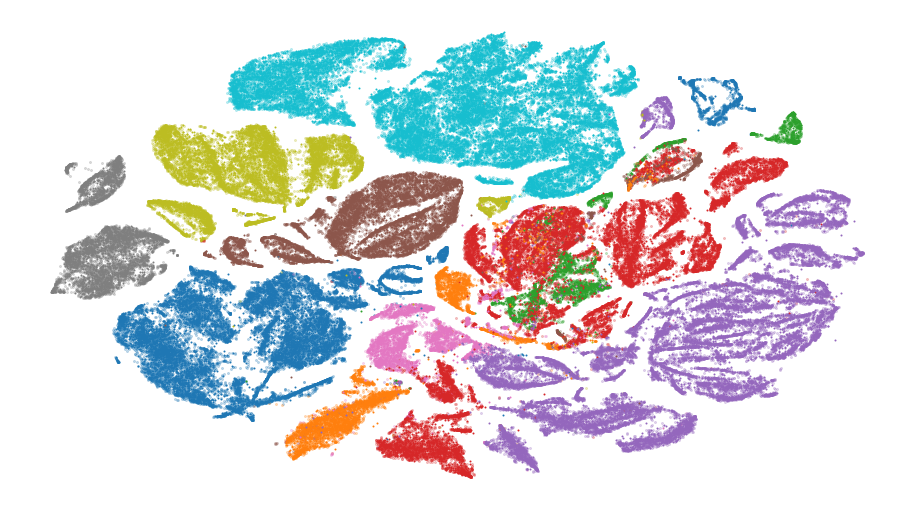

In [18]:
fig = plt.figure(figsize=(16, 9))
utils.plot(embedding_train, y_train, ax=fig.gca(), alpha=0.25, ms=2, draw_legend=False)
plt.gca().set_prop_cycle(None)
utils.plot(embedding_test, y_test, ax=fig.gca(), alpha=1, draw_legend=False)